In [1]:
from pydantic import BaseModel
import pandas as pd 
import os
from dotenv import load_dotenv
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
load_dotenv()
import os 
from langchain_core.messages import HumanMessage, SystemMessage
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GOOGLE_SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")
from typing import Annotated, Literal, TypedDict

import bs4

from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough,RunnableLambda
from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings
from langchain_groq import ChatGroq
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from langchain.utilities import GoogleSerperAPIWrapper
from langchain.load import dumps, loads
from langchain.prompts import PromptTemplate,ChatPromptTemplate
from langchain_google_genai import GoogleGenerativeAIEmbeddings,ChatGoogleGenerativeAI
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
# llm = ChatGoogleGenerativeAI(
#     model="gemini-1.5-pro",
#     temperature=0,
#     max_tokens=None,
#     timeout=None,
#     max_retries=2,
#     # other params...
# )
llm = ChatGroq(temperature=0, model_name="Gemma2-9b-It")
from langgraph.graph.message import add_messages
from pydantic import BaseModel,Field
from langchain_core.tools import tool
from langgraph.graph import StateGraph,MessagesState,END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph import START,END

import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


USER_AGENT environment variable not set, consider setting it to identify your requests.
/home/puzan/anaconda3/envs/study/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class overallstate(TypedDict):
    foo:int
class privatestate(TypedDict):
    baz:int 


def node_1(state:overallstate)->privatestate:
    return {"baz": state["foo"]+1}

def node_2(state:privatestate)->overallstate:
    return {"foo": state["baz"]+1}

builder=StateGraph(overallstate)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

builder.add_edge(START,"node_1")
builder.add_edge("node_1","node_2")
builder.add_edge("node_2",END)

graph=builder.compile()



In [3]:
graph.invoke({"foo":1})

{'foo': 3}

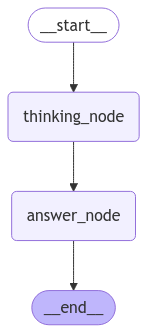

In [4]:
class overallstate(TypedDict):
    question:str
    answer:str
    notes:str

def thinking_nodes(state:overallstate):
    return {"answer":"bye","notes":"hi my name is lance"}

def answer_node(state:overallstate):
    return {"answer":"bybyedoctor"}


graph = StateGraph(overallstate)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_nodes)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [5]:
graph.invoke({"question":"hi"})

{'question': 'hi', 'answer': 'bybyedoctor', 'notes': 'hi my name is lance'}

In [ ]:
class Inputstate(TypedDict):
    question:str

class OutputState(TypedDict):
    answer:str

class overallstate(TypedDict):
    question :str 
    answer:str
    notes:str 

def thinking_nodes(state:Inputstate):
    return {"answer":"bye","notes":"jjjn"}

def answer_node(state:Inputstate):
    return {"answer":"bybyedoctor"}
graph = StateGraph(overallstate, input=Inputstate, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_nodes)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})

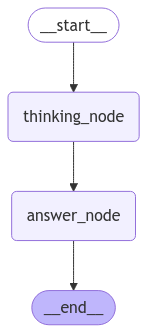

In [10]:
graph = StateGraph(overallstate, input=Inputstate, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_nodes)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

result=graph.invoke({"question":"hi"})

In [11]:
result

{'answer': 'bybyedoctor'}

In [9]:
from pydantic import BaseModel, Field
from langchain.agents import Tool
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

from langchain.agents import initialize_agent
import csv
import os

# Step 1: Define User Details Model
class UserDetails(BaseModel):
    name: str | None = Field(None, description="User's name")
    phone: str | None = Field(None, description="User's phone number")
    email: str | None = Field(None, description="User's email address")

# Step 2: Create a Tool Function
def check_what_is_empty(user_personal_details: UserDetails):
    """Check for empty fields in user details."""
    ask_for = []
    for field, value in user_personal_details.dict().items():
        if value in [None, "", 0]:
            ask_for.append(field)
    return ask_for

# Define the tool for LangChain
check_tool = Tool(
    name="CheckEmptyFields",
    func=check_what_is_empty,
    description="Check which fields in user details are empty."
)


agent = initialize_agent([check_tool], llm, agent_type="zero-shot-react-description")

# Function to collect user data and save it to CSV
def collect_user_data():
    user_details = UserDetails()
    
    # Collecting data from the user
    user_details.name = input("Please enter your name: ")
    user_details.phone = input("Please enter your phone number: ")
    user_details.email = input("Please enter your email address: ")

    # Check for empty fields using the LangChain agent
    empty_fields = agent.run(user_details)
    
    if empty_fields:
        print(f"The following fields are empty: {empty_fields}")
        return
    
    # Save data to CSV if all fields are filled
    save_to_csv(user_details)

def save_to_csv(user_details: UserDetails):
    csv_file_path = 'user_details.csv'
    
    # Check if file exists to write header only once
    write_header = not os.path.isfile(csv_file_path)
    
    with open(csv_file_path, mode='a', newline='') as csv_file:
        fieldnames = ['name', 'phone', 'email']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        
        if write_header:
            writer.writeheader()  # Write header if file is new
            
        writer.writerow({'name': user_details.name, 'phone': user_details.phone, 'email': user_details.email})
    
    print(f"Data saved to {csv_file_path}")

# Main execution flow
if __name__ == "__main__":
    collect_user_data()


/tmp/ipykernel_102678/3154908720.py:33: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. See LangGraph documentation for more details: https://langchain-ai.github.io/langgraph/. Refer here for its pre-built ReAct agent: https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/
  agent = initialize_agent([check_tool], llm, agent_type="zero-shot-react-description")
/tmp/ipykernel_102678/3154908720.py:45: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  empty_fields = agent.run(user_details)


AttributeError: 'str' object has no attribute 'dict'